# Weak/Integral SINDy Feature Overview
It is often difficult to identify dynamical systems in the presence of substantial noise. Towards that end, a number of publications have used SINDy to identify the weak-formulation (integral formulation) of the system of ODEs or PDEs. This allows one to avoid taking high-order derivatives of noisy data (high-order derivatives of noisy data will amplify the noise). 

This notebook provides a simple overview of the weak form PDE functionality of PySINDy, following the examples in the PDE-FIND paper (Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. "Data-driven discovery of partial differential equations." Science Advances 3, no. 4 (2017): e1602614) and Reinbold, P. A., Gurevich, D. R., & Grigoriev, R. O. (2020). Using noisy or incomplete data to discover models of spatiotemporal dynamics. Physical Review E, 101(1), 010203. Jupyter notebook written by Alan Kaptanoglu and Zachary Nicolaou.

As of release 1.7, the weak formulation is vectorized and much faster to compute. The "num_pts_per_domain" variable is now deprecated. It can still be passed to the WeakPDELibrary to avoid breaking old code, but it will raise a DeprecationWarning and do nothing to the library.

An interactive version of this notebook is available on binder
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7.3?filepath=examples/12_weakform_SINDy_examples.ipynb)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

# integration keywords for solve_ivp, typically needed for chaotic systems
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# Test weak form ODE functionality on Lorenz equation

In [2]:
# Generate measurement data
dt = 0.002
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u_train = solve_ivp(lorenz, t_train_span, u0_train, 
                    t_eval=t_train, **integrator_keywords).y.T

# Instantiate and fit the SINDy model with u_dot
u_dot = ps.FiniteDifference()._differentiate(u_train, t=dt)
model = ps.SINDy()
model.fit(u_train, x_dot=u_dot, t=dt)
model.print()

# Define weak form ODE library
# defaults to derivative_order = 0 if not specified,
# and if spatial_grid is not specified, defaults to None,
# which allows weak form ODEs.
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    is_uniform=True,
    K=100,
)

# Instantiate and fit the SINDy model with the integral of u_dot
optimizer = ps.SR3(
    threshold=0.05, 
    thresholder="l1", 
    max_iter=1000, 
    normalize_columns=True, 
    tol=1e-1
)
model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
model.fit(u_train)
model.print()

(x0)' = -9.999 x0 + 9.999 x1
(x1)' = 27.992 x0 + -0.999 x1 + -1.000 x0 x2
(x2)' = -2.666 x2 + 1.000 x0 x1
(x0)' = -10.000 x0 + 10.000 x1
(x1)' = 28.000 x0 + -1.000 x1 + -1.000 x0x2
(x2)' = -2.667 x2 + 1.000 x0x1


Performance should improve as the number of sub-domain integrations points increases (numerically approximating the integrals better and better) and number of sub-domains increases (more points for regression). Let's use some noisy Lorenz data and investigate.

In [3]:
# Generate measurement data
dt = 0.001
t_train = np.arange(0, 10, dt)
t_train_span = (t_train[0], t_train[-1])
u0_train = [-8, 8, 27]
u0_test = [8, 7, 15]
u_train = solve_ivp(lorenz, t_train_span, u0_train, 
                    t_eval=t_train, **integrator_keywords).y.T
u_test = solve_ivp(lorenz, t_train_span, u0_test, 
                   t_eval=t_train, **integrator_keywords).y.T
rmse = mean_squared_error(u_train, np.zeros((u_train).shape), squared=False)
u_dot_clean = ps.FiniteDifference()._differentiate(u_test, t=dt)
u_clean = u_test
u_train = u_train + np.random.normal(0, rmse / 5.0, u_train.shape)  # Add 20% noise
rmse = mean_squared_error(u_test, np.zeros(u_test.shape), squared=False)
u_test = u_test + np.random.normal(0, rmse / 5.0, u_test.shape)  # Add 20% noise
u_dot = ps.FiniteDifference()._differentiate(u_test, t=dt)

# Same library terms as before
library_functions = [lambda x: x, lambda x: x * x, lambda x, y: x * y]
library_function_names = [lambda x: x, lambda x: x + x, lambda x, y: x + y]

# Scan over the number of integration points and the number of subdomains
n = 10
errs = np.zeros((n))
K_scan = np.linspace(20, 2000, n, dtype=int)
for i, K in enumerate(K_scan):
    ode_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        spatiotemporal_grid=t_train,
        include_bias=True,
        is_uniform=True,
        K=K,
    )
    opt = ps.SR3(
        threshold=0.05,
        thresholder="l0",
        max_iter=1000,
        normalize_columns=True,
        tol=1e-1,
    )
    u_dot_train_integral = ode_lib.convert_u_dot_integral(u_train)

    # Instantiate and fit the SINDy model with the integral of u_dot
    model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
    model.fit(u_train, quiet=True)
    errs[i] = np.sqrt(
        (
            np.sum((u_dot_train_integral - opt.Theta_ @ opt.coef_.T) ** 2)
            / np.sum(u_dot_train_integral ** 2)
        )
        / u_dot_train_integral.shape[0]
    )

Performance clearly improves as the number of subdomains increases! We can also see that Lorenz is correctly identified despite ~20% noise levels.

The plot belows shows that we can use the weak-formulation to build models that are robust to noise, and additionally indicates convergence as the regression becomes larger and more accurate. 

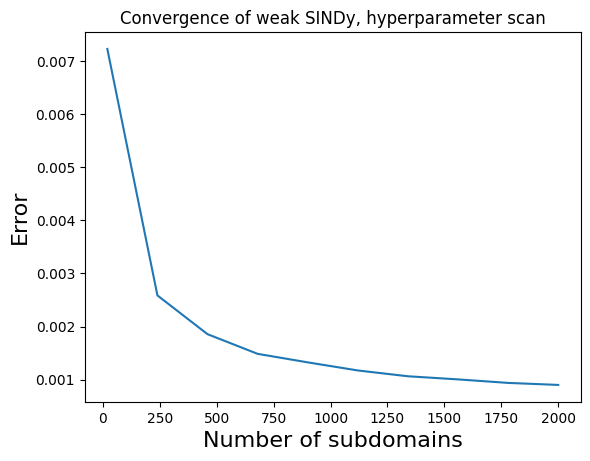

In [4]:
plt.title('Convergence of weak SINDy, hyperparameter scan', fontsize=12)
plt.plot(K_scan,errs)
plt.xlabel('Number of subdomains', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.show()

The default scikit-learn functionality for `model.predict` is to return x_dot of the same type as the training data. So for weak form, model.predict returns a prediction of the weak form of x_dot, rather than a prediction of x_dot.

We can get around this with a bit of a cheat... inputting the model coefficients from the weak form into the original (not weak) model, and use this to predict!
Beware, this requires: 
1. That the libraries and library ordering are identical in the two models!
2. For PDEs, the spatial grids must be identical. This means you need to reuse the library. If you initialize a new PDE library, a new set of subdomains is randomly chosen.
3. Note that the candidate libraries $\Theta$ are fundamentally different in the weak and non-weak models. In the former, all the columns are integrated in time (and for PDEs, also in space)! This means if you forecast the weak model coefficients with the non-weak model, you are using a $\Theta$ matrix that is very noisy! In other words, using the weak form fixed the issues with noise, but forecasting with the original model still has the noise in $\Theta$.
4. For all these reasons, we will use the error in the coefficients, rather than the error in the predictions, after this example.

Weak form model: 
(x0)' = -3.753 1 + -11.421 x0 + 10.970 x1 + 0.486 x2 + 0.084 x0x0 + -0.015 x2x2 + -0.058 x0x1 + 0.043 x0x2 + -0.032 x1x2
(x1)' = 13.899 1 + 29.630 x0 + -1.449 x1 + -1.495 x2 + -0.228 x0x0 + -0.076 x1x1 + 0.044 x2x2 + 0.249 x0x1 + -1.042 x0x2
(x2)' = -2.556 x2 + 0.105 x0x0 + -0.008 x2x2 + 0.924 x0x1
Regular model: 
(x0)' = -52.763 1 + -7.108 x0 + 10.803 x1 + 4.585 x2 + 0.366 x0x0 + 0.074 x1x1 + -0.088 x2x2 + -0.459 x0x1 + 0.206 x0x2 + -0.370 x1x2
(x1)' = 13.274 1 + 1.810 x0 + 14.251 x1 + -1.394 x2 + 0.492 x0x0 + -0.099 x1x1 + 0.005 x2x2 + -0.119 x0x1 + -0.053 x0x2 + -0.595 x1x2
(x2)' = -2.659 1 + -10.136 x0 + 6.471 x1 + -4.319 x2 + -0.329 x0x0 + 0.708 x1x1 + 0.110 x2x2 + -0.012 x0x1 + 0.323 x0x2 + -0.248 x1x2


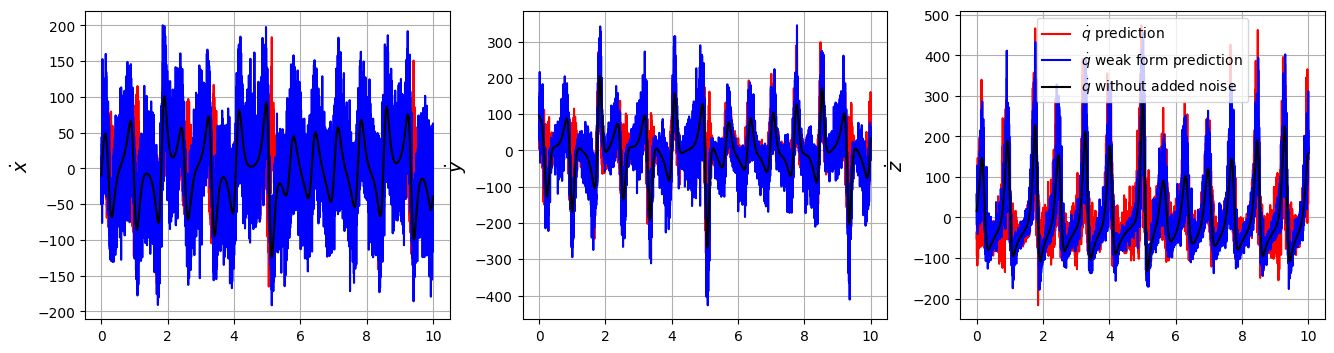

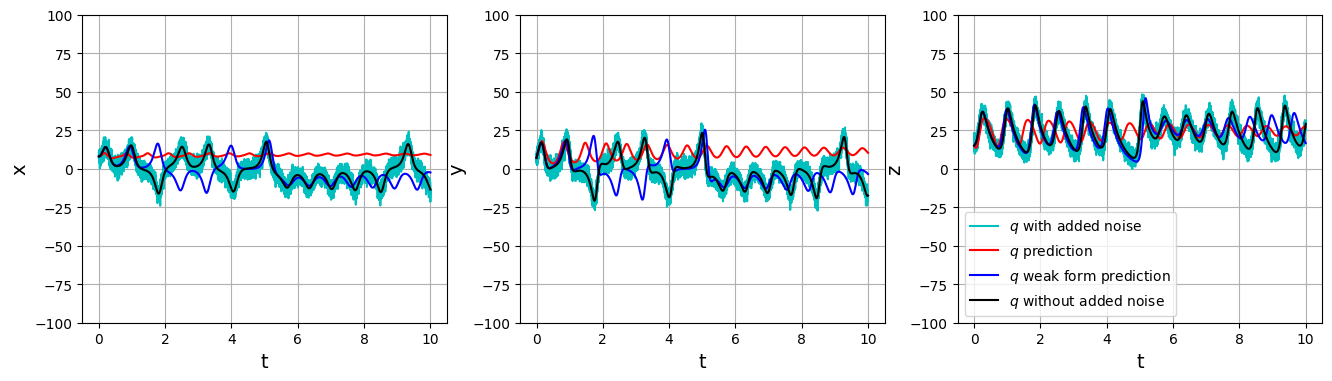

In [5]:
# Fit a weak form model
ode_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    spatiotemporal_grid=t_train,
    include_bias=True,
    is_uniform=True,
    K=5000,
)
opt = ps.SR3(
    threshold=100, 
    thresholder="l0", 
    max_iter=10000, 
    normalize_columns=True, 
    tol=1e-10
)
model = ps.SINDy(feature_library=ode_lib, optimizer=opt)
model.fit(u_train, quiet=True)
print("Weak form model: ")
model.print()

# Instantiate and fit a non-weak SINDy model
ode_lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=True,
)
optimizer = ps.SR3(
    threshold=100, 
    thresholder="l0", 
    max_iter=10000, 
    normalize_columns=True, 
    tol=1e-10
)
original_model = ps.SINDy(feature_library=ode_lib, optimizer=optimizer)
original_model.fit(u_train, t=dt, quiet=True)
print("Regular model: ")
original_model.print()
err_not_weak = np.sqrt(
    (np.sum((u_dot - optimizer.Theta_ @ optimizer.coef_.T) ** 2) / np.sum(u_dot ** 2))
    / u_dot.shape[0]
)

u_pred = original_model.simulate(u0_test, t=t_train, integrator='odeint')
u_dot_pred = original_model.predict(u_test)

# Plot the ground truth, weak form, and non-weak derivative predictions
feature_names = ['x', 'y', 'z']
optimizer.coef_ = opt.coef_
u_dot_weak = original_model.predict(u_test)
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_dot_pred[:, i], "r", label=r"$\dot{q}$ prediction")
    plt.plot(t_train, u_dot_weak[:, i], "b", label=r"$\dot{q}$ weak form prediction")
    plt.plot(t_train, u_dot_clean[:, i], "k", label=r"$\dot{q}$ without added noise")
    plt.grid(True)
    plt.ylabel(r'$\dot{' + feature_names[i] + '}$', fontsize=14)
    if i == 2:
        plt.legend()

# Plot the ground truth, weak form, and non-weak trajectory predictions
u_weak = original_model.simulate(u0_test, t=t_train, integrator='odeint')
plt.figure(figsize=(16, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(t_train, u_test[:, i], "c", label=r"$q$ with added noise")
    plt.plot(t_train, u_pred[:, i], "r", label=r"$q$ prediction")
    plt.plot(t_train, u_weak[:, i], "b", label=r"$q$ weak form prediction")
    plt.plot(t_train, u_clean[:, i], "k", label=r"$q$ without added noise")
    plt.grid(True)
    plt.ylabel(feature_names[i], fontsize=14)
    plt.xlabel('t', fontsize=14)
    plt.ylim(-100, 100)
    if i == 2:
        plt.legend()

# Test weak form PDE functionality on Burgers' equation with 20% noise
Note that the weak formulation can be applied to PDEs too. 
Burgers' equation is
$u_t = -uu_x + 0.1 u_{xx}$. We will repeat all the same steps. Although weak-formulation helps with noisy data, we also show that using smoothed finite-differences (or other more advanced differentiation schemes) can also improve robustness to noise.

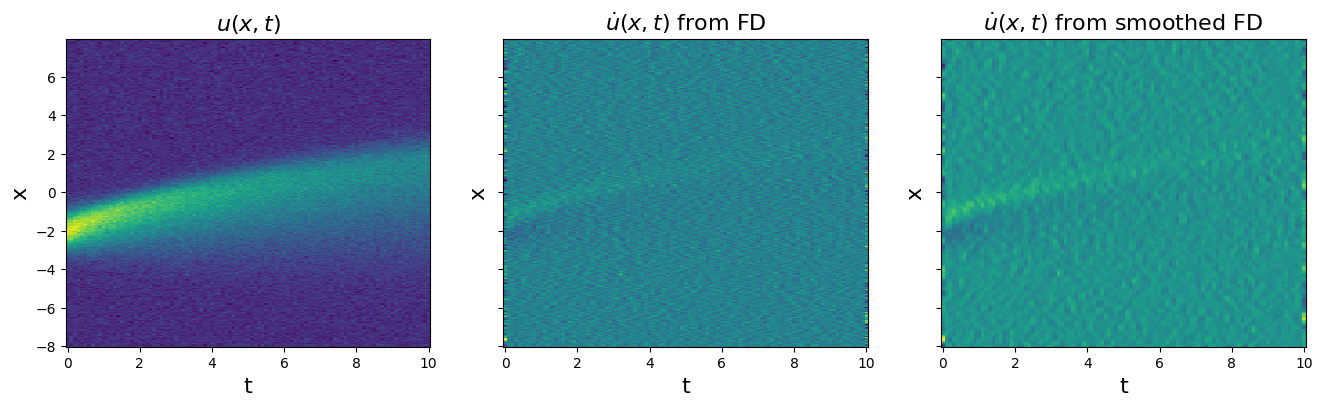

In [6]:
data = loadmat('data/burgers.mat')
time = np.ravel(data['t'])
x = np.ravel(data['x'])
u = np.real(data['usol'])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
u = u + np.random.normal(0, rmse / 5.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from FD', fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$ from smoothed FD', fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [7]:
# Define weak form PDE library 
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2,
                            spatiotemporal_grid=XT,
                            is_uniform=True, K=1000,
                            )

In [8]:
# Fit a weak form model
optimizer = ps.SR3(threshold=0.1, thresholder='l0', 
                   tol=1e-8, normalize_columns=True, max_iter=1000)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

(x0)' = 0.096 x0_11 + -0.997 x0x0_1


In [9]:
# Show that a non-weak form model screws this up badly
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=x,
                        include_bias=False,
                        is_uniform=True)

# Fit and predict with the non-weak model
opt = ps.SR3(threshold=0.05, thresholder='l0', 
             tol=1e-10, normalize_columns=True, 
             max_iter=1000)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u)

# Prints a very wrong model
model_for_prediction.print()

(x0)' = 0.012 x0 + -0.033 x0x0 + -0.015 x0x0_1 + -0.015 x0x0x0_1


The takeaway here is that the weak formulation drastically improved our system identification on the Burgers' equation with added noise. The weak formulation can handle even more than 20% noise here, although then a fairly large value for K is required to obtain a decent system identification. This is required for some of the examples below, and the downside is that this slows down the code considerably. 

# Test weak form PDE functionality on 2d compressible isothermal flow equations with mixed function-derivative terms
Here we fit  the coupled momentum and mass transport equations in two dimensions
$$ \mathbf{u}_ t = -(\mathbf{u}\cdot\nabla)\mathbf{u} + (-\nabla P + \mu \nabla^2 \mathbf{u})/\rho,$$
$$ \rho_ t = -\nabla \cdot(\rho \mathbf{u}),$$
where we use the isothermal ideal gas law $ P = \rho R T$ as the equation of state.
Unlike the other PDE examples shown, these equations contains mixed derivative/function terms like $\rho^{-1} u_{xx}$, so this is a nice check that the full PDE functionality works,

In [10]:
def compressible (t, U, dx, N, mu, RT):
    u = U.reshape(N,N,3)[:,:,0]
    v = U.reshape(N,N,3)[:,:,1]
    rho = U.reshape(N,N,3)[:,:,2]
    ux = ps.differentiation.SpectralDerivative(
            d=1, axis=0, 
         )._differentiate(u, dx)
    uy = ps.differentiation.SpectralDerivative(
            d=1, axis=1, 
         )._differentiate(u, dx)
    uxx = ps.differentiation.SpectralDerivative(
            d=2, axis=0, 
         )._differentiate(u, dx)
    uyy = ps.differentiation.SpectralDerivative(
            d=2, axis=1, 
         )._differentiate(u, dx)
    vx = ps.differentiation.SpectralDerivative(
            d=1, axis=0, 
         )._differentiate(v, dx)
    vy = ps.differentiation.SpectralDerivative(
            d=1, axis=1, 
         )._differentiate(v, dx)
    vxx = ps.differentiation.SpectralDerivative(
            d=2, axis=0, 
         )._differentiate(v, dx)
    vyy = ps.differentiation.SpectralDerivative(
            d=2, axis=1, 
         )._differentiate(v, dx)
    px = ps.differentiation.SpectralDerivative(
            d=1, axis=0,
         )._differentiate(rho*RT, dx)
    py = ps.differentiation.SpectralDerivative(
            d=1, axis=1,
         )._differentiate(rho*RT, dx)
    ret=np.zeros((N,N,3))
    ret[:,:,0]=-(u*ux+v*uy)-(px-mu*(uxx+uyy))/rho
    ret[:,:,1]=-(u*vx+v*vy)-(py-mu*(vxx+vyy))/rho
    ret[:,:,2]=-(u*px/RT+v*py/RT+rho*ux+rho*vy)
    return ret.reshape(3*N*N)

N = 100
h0 = 1.0
L = 5
T = 0.5
mu=1
RT=1

t = np.linspace(0, T, N)
x = np.arange(0, N) * L / N
y = np.arange(0, N) * L / N
dx = x[1] - x[0]

#some arbitrary initial conditions
y0=np.zeros((N,N,3))
y0[:,:,0]=-np.sin(2*np.pi/L*x)[:,np.newaxis]+0.5*np.cos(2*2*np.pi/L*y)[np.newaxis,:]
y0[:,:,1]=0.5*np.cos(2*np.pi/L*x)[:,np.newaxis]-np.sin(2*2*np.pi/L*y)[np.newaxis,:]
y0[:,:,2]=1+0.5*np.cos(2*np.pi/L*x)[:,np.newaxis]*np.cos(2*2*np.pi/L*y)[np.newaxis,:]

sol = solve_ivp(compressible, (t[0], t[-1]), 
                y0=y0.reshape(3*N*N), t_eval=t, args=(dx, N, mu, RT),
                method='RK45', rtol=1e-12, atol=1e-12,
               )

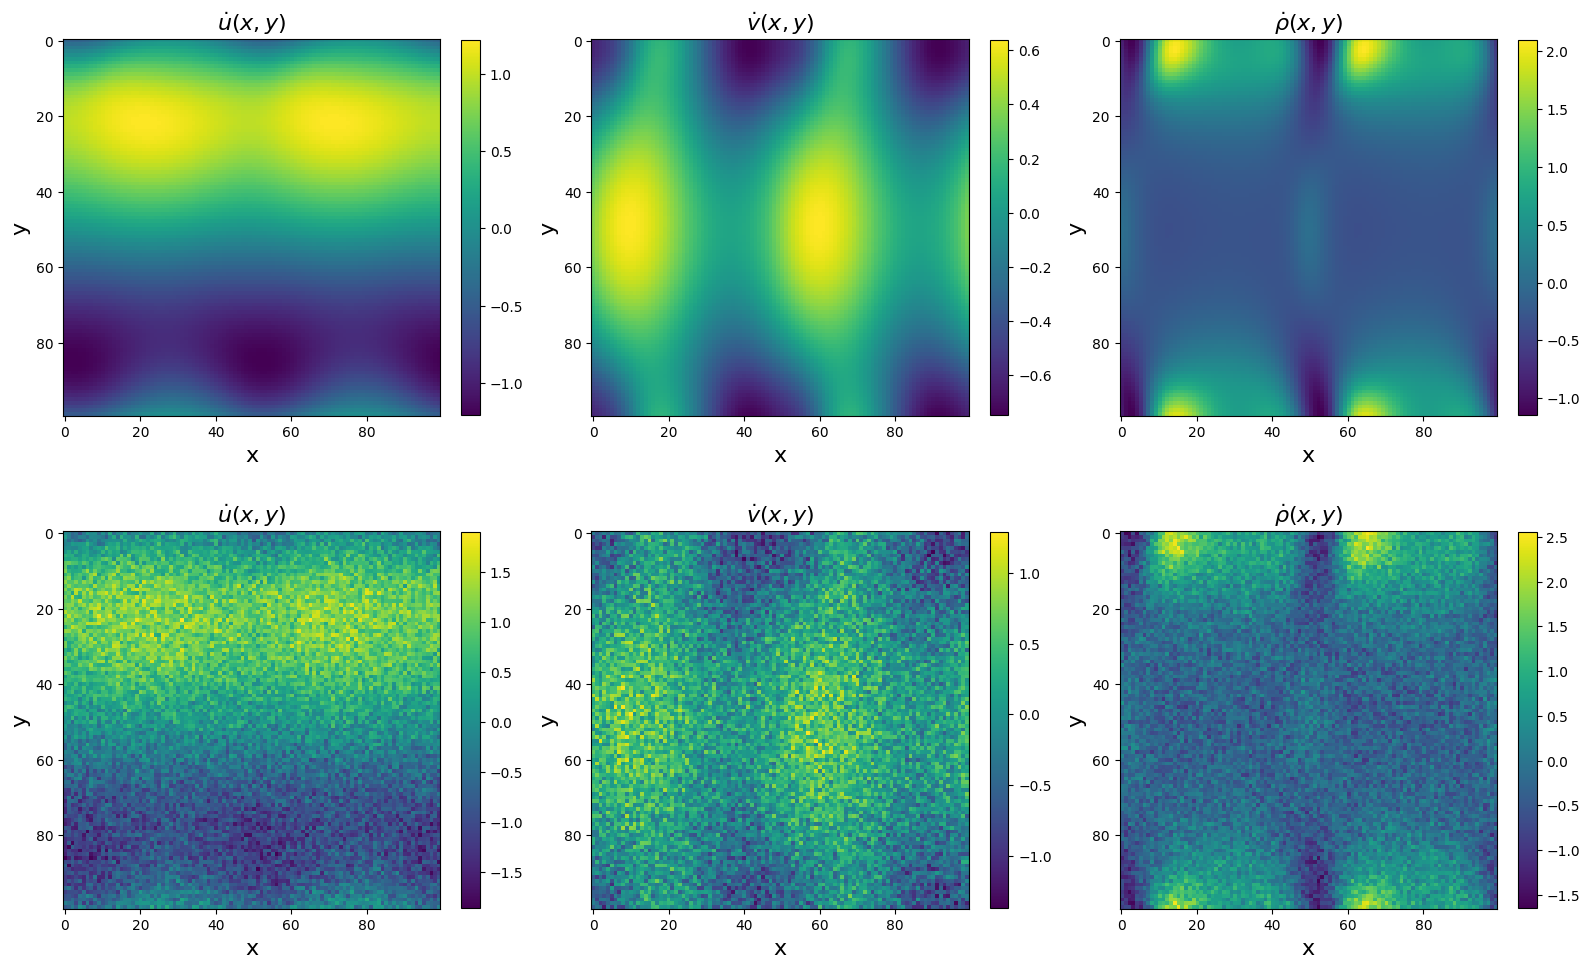

In [11]:
u_shaped_noiseless = sol.y.reshape(N,N,3,-1).transpose(0,1,3,2)
u_dot_noiseless = ps.FiniteDifference(
    d=1, axis=2
)._differentiate(u_shaped_noiseless,t)

ep = 1e-3
np.random.seed(100)
u_shaped_noisy = u_shaped_noiseless + 2 * ep * (
    0.5 - np.random.random(size=(N, N, N, 3))
)
u_dot_noisy = ps.FiniteDifference(
    d=1, axis=2)._differentiate(u_shaped_noisy, t)

# Plot u and u_dot
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.imshow(u_dot_noiseless[:,:,-1,0])
plt.colorbar(fraction=0.045)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title(r'$\dot{u}(x, y)$', fontsize=16)

plt.subplot(2, 3, 2)
plt.imshow(u_dot_noiseless[:,:,-1,1])
plt.colorbar(fraction=0.045)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title(r'$\dot{v}(x, y)$', fontsize=16)

plt.subplot(2, 3, 3)
plt.imshow(u_dot_noiseless[:,:,-1,2])
plt.colorbar(fraction=0.045)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title(r'$\dot{\rho}(x, y)$', fontsize=16)

plt.subplot(2, 3, 4)
plt.imshow(u_dot_noisy[:,:,-1,0])
plt.colorbar(fraction=0.045)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
plt.title(r'$\dot{u}(x, y)$', fontsize=16)

plt.subplot(2, 3, 5)
plt.imshow(u_dot_noisy[:,:,-1,1])
plt.colorbar(fraction=0.045)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
plt.title(r'$\dot{v}(x, y)$', fontsize=16)

plt.subplot(2, 3, 6)
plt.imshow(u_dot_noisy[:,:,-1,2])
plt.colorbar(fraction=0.045)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
plt.title(r'$\dot{\rho}(x, y)$', fontsize=16)

plt.tight_layout()
plt.show()

#### Regular PDELibrary fails for noisy data!

In [12]:
spatial_grid=np.zeros((N,N,2))
spatial_grid[:,:,0]=x[:,np.newaxis]
spatial_grid[:,:,1]=y[np.newaxis,:]

library_functions = [
    lambda x: x, lambda x:1/(1e-6+abs(x))
]
library_function_names = [
    lambda x: x, lambda x: x+'^-1'
]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    is_uniform=True,
    multiindices=np.array([[0,1],[1,0],[0,2],[2,0]],dtype=int),
    differentiation_method=ps.SpectralDerivative
)

# Fit the clean data (prints the correct model)
optimizer = ps.STLSQ(threshold=5e-1, alpha=1e-10, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u', 'v', 'p'])
model.fit(u_shaped_noiseless, t=t)
model.print()
print("R2 score: ", model.score(u_shaped_noiseless, t=t))

# Fit the noisy data (prints a bad model)
optimizer = ps.STLSQ(threshold=5e-1, alpha=1e-10, normalize_columns=False)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer, feature_names=['u', 'v', 'p'])
model.fit(u_shaped_noisy, t=t)
model.print()
print("R2 score: ", model.score(u_shaped_noisy, t=t))

(u)' = -1.001 vu_2 + -1.000 uu_1 + -1.000 p^-1p_1 + 1.000 p^-1u_22 + 1.000 p^-1u_11
(v)' = -1.001 vv_2 + -1.000 p^-1p_2 + -1.000 uv_1 + 1.000 p^-1v_22 + 1.000 p^-1v_11
(p)' = -1.000 pv_2 + -1.000 vp_2 + -1.000 pu_1 + -1.000 up_1
R2 score:  0.9999986660041902
(u)' = -1.974 u + -0.901 vu_2 + 0.836 p^-1v_2 + -0.595 uu_1
(v)' = -1.595 v + -4.100 p^-1u_2 + -0.838 vv_2
(p)' = -0.999 pv_2 + -0.998 vp_2 + -0.999 pu_1 + -0.995 up_1
R2 score:  0.9629476917409668


#### WeakPDELibrary works great for noisy data!

In [13]:
spatiotemporal_grid=np.zeros((N,N,N,3))
spatiotemporal_grid[:,:,:,0]=x[:,np.newaxis,np.newaxis]
spatiotemporal_grid[:,:,:,1]=y[np.newaxis,:,np.newaxis]
spatiotemporal_grid[:,:,:,2]=t[np.newaxis,np.newaxis,:]

library_functions = [
    lambda x: x, lambda x:1/(1e-6+abs(x))
]
library_function_names = [
    lambda x: x, lambda x: x+'^-1'
]
np.random.seed(100)

weak_pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    K=2000,
    H_xt=[L/10,L/10,T/10],
    multiindices=np.array([[0,1],[1,0],[0,2],[2,0]],dtype=int),
    differentiation_method=ps.SpectralDerivative
)

# Fit the clean data 
optimizer = ps.STLSQ(threshold=5e-1, alpha=1e-10, normalize_columns=False)
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, feature_names=['u', 'v', 'p'])
model.fit(u_shaped_noiseless, t=t)
model.print()
print("R2 score: ", model.score(u_shaped_noiseless, t=t))

# Fit the noisy data 
optimizer = ps.STLSQ(threshold=5e-1, alpha=1e-10, normalize_columns=False)
model = ps.SINDy(feature_library=weak_pde_lib, optimizer=optimizer, feature_names=['u', 'v', 'p'])
model.fit(u_shaped_noisy, t=t)
model.print()
print("R2 score: ", model.score(u_shaped_noisy, t=t))

(u)' = -1.000 vu_2 + -1.000 uu_1 + -1.000 p^-1p_1 + 1.000 p^-1u_22 + 1.000 p^-1u_11
(v)' = -1.000 vv_2 + -1.000 p^-1p_2 + -1.000 uv_1 + 1.000 p^-1v_22 + 1.000 p^-1v_11
(p)' = -1.000 pv_2 + -1.000 vp_2 + -1.000 pu_1 + -1.000 up_1
R2 score:  0.9999999999999859
(u)' = -1.000 vu_2 + -1.000 uu_1 + -1.000 p^-1p_1 + 1.000 p^-1u_22 + 1.000 p^-1u_11
(v)' = -1.000 vv_2 + -1.000 p^-1p_2 + -1.000 uv_1 + 1.000 p^-1v_22 + 1.000 p^-1v_11
(p)' = -1.000 pv_2 + -1.000 vp_2 + -1.000 pu_1 + -1.000 up_1
R2 score:  0.9999988896743934


# Test weak-formulation PDE functionality on the Kuramoto-Sivashinsky equation
The Kuramoto-Sivashinsky equation is
$u_t = -uu_x - u_{xx} - u_{xxxx}$. We will skip noisy data for now, since we have already illustrated the pitfalls and performance with the weak form. We will revisit noisy data for the 2D reaction-diffusion example.

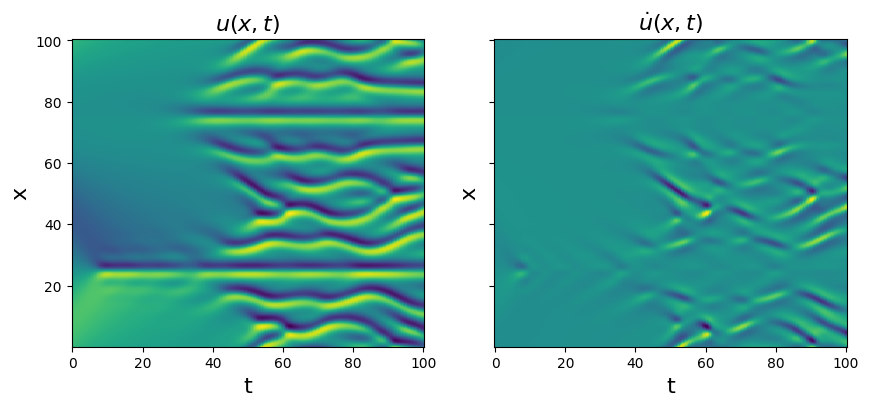

In [14]:
# Load and plot the data
data = loadmat('data/kuramoto_sivishinky.mat')
time = np.ravel(data['tt'])
x = np.ravel(data['x'])
u = data['uu']
dt = time[1] - time[0]
dx = x[1] - x[0]

# Plot u and u_dot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolormesh(time, x, u)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 2, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel('t', fontsize=16)
plt.ylabel('x', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

u = u.reshape(len(x), len(time), 1)

In [15]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=200,
    include_interaction=True,
    periodic=True
)

In [16]:
# Run optimizers 
optimizer = ps.STLSQ(threshold=0.4, alpha=0.05, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.SR3(
    threshold=0.8, max_iter=1000,
    thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.SR3(
    threshold=0.2, max_iter=1000,
    thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.SSR(normalize_columns=True, kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.SSR(criteria='model_residual', normalize_columns=True, 
                   kappa=1e-20, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

optimizer = ps.FROLS(normalize_columns=True, kappa=1e-20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
(x0)' = -0.998 x0_11 + -0.999 x0_1111 + -1.002 x0x0_1
(x0)' = -0.999 x0_11 + -0.999 x0_1111 + -1.002 x0x0_1
(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111
(x0)' = -1.000 x0_11 + -1.000 x0_1111 + -1.000 x0x0_1 + 0.002 x0x0_111


**Okay, so all the optimizers essentially capture the model but often have some much smaller "extra" terms.**
The best way to deal with these spurious terms is to use ensembling, i.e. the generation of many models by sub-sampling the data, or sub-sampling the SINDy candidate library. See notebook 13 for many examples of how to use these methods. 

You can also deal with this by scanning over the hyperparameters for each method although this is more laborious for the user. 

**Next we try the SR3 optimizer on the same data but with added noise of varying levels to illustrate the robustness to noisy data.**
Ideally, we would cross-validate over 10-20 noise instantiations, but with this high-dimensional data this can be computationally slow. We compute the coefficient model errors defined through
$$\Delta\xi_{u_{xx}} = \|\xi_{u_{xx}}^{true} - \xi_{u_{xx}}^{pred}\| / \|\xi_{u_{xx}}^{true}\| =  \|-1 - \xi_{u_{xx}}^{pred}\|,$$
and similarly for the other coefficients.

In [17]:
# Get average SR3 performance as function of the noise level.
cross_val_runs = 1
u = np.squeeze(u)
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
noise_levels = np.linspace(0, rmse / 2.0, 5)
delta_c1 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c2 = np.zeros((cross_val_runs, len(noise_levels)))
delta_c3 = np.zeros((cross_val_runs, len(noise_levels)))

# Make a weak form library with high-resolution
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatiotemporal_grid=XT,
    K=400,
    is_uniform=True,
)
# Pick an optimizer with some plausible hyperparameters
optimizer = ps.SR3(
    threshold=1, max_iter=1000,
    thresholder="l0", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
# Loop over noisy data and cross-validate
for i in range(cross_val_runs):
    for j, noise in enumerate(noise_levels):
        u_noisy = u + np.random.normal(0, noise, u.shape)
        u_noisy = np.reshape(u_noisy, (len(x), len(time), 1))
        model.fit(u_noisy, quiet=True)
        model.print()
        c1 = abs(optimizer.coef_[0, 6])
        c2 = abs(optimizer.coef_[0, 3])
        c3 = abs(optimizer.coef_[0, 5])
        delta_c1[i, j] = abs(abs(c1 - 1.0) / c1)
        delta_c2[i, j] = abs(abs(c2 - 1.0) / c2)
        delta_c3[i, j] = abs(abs(c3 - 1.0) / c3)

(x0)' = -0.998 x0_11 + -0.999 x0_1111 + -1.002 x0x0_1
(x0)' = -0.994 x0_11 + -0.994 x0_1111 + -0.999 x0x0_1
(x0)' = 0.006 x0 + -0.995 x0_11 + -0.997 x0_1111 + -1.005 x0x0_1
(x0)' = -0.989 x0_11 + -0.988 x0_1111 + -1.006 x0x0_1 + -0.001 x0x0_11 + -0.001 x0x0x0_11
(x0)' = 0.018 x0 + -0.976 x0_11 + -0.975 x0_1111 + -0.986 x0x0_1 + 0.002 x0x0_11 + 0.001 x0x0x0_11


Now that we have computed the error in the model coefficients at each noise level, we plot the results.
We show below that the weak form nicely works for even 50% Gaussian noise added to every point, showing the power of the weak-formulation for robust system identification.

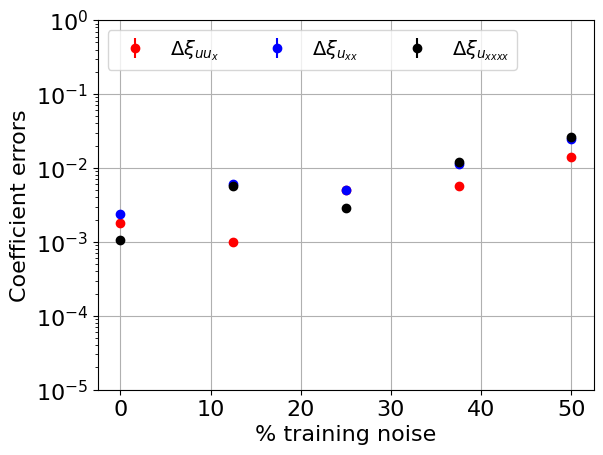

In [18]:
# Find mean and std over the validation runs
delta_c1_mean = np.nanmean(delta_c1, axis=0)
delta_c2_mean = np.nanmean(delta_c2, axis=0)
delta_c3_mean = np.nanmean(delta_c3, axis=0)

delta_c1_std = np.nanstd(delta_c1, axis=0)
delta_c2_std = np.nanstd(delta_c2, axis=0)
delta_c3_std = np.nanstd(delta_c3, axis=0)

# Plot average and standard deviations of the coefficient errors
plt.figure()
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c1_mean,
    yerr=delta_c1_std,
    color="r",
    fmt="o",
    label=r"$\Delta\xi_{uu_x}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c2_mean,
    yerr=delta_c2_std,
    color="b",
    fmt="o",
    label=r"$\Delta\xi_{u_{xx}}$",
)
plt.errorbar(
    noise_levels / rmse * 100,
    y=delta_c3_mean,
    yerr=delta_c3_std,
    color="k",
    fmt="o",
    label=r"$\Delta\xi_{u_{xxxx}}$",
)
plt.yscale("log")
plt.legend(
    fontsize=14, loc="upper left", ncol=3
)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_ylim(1e-5, 1)
plt.xlabel('% training noise', fontsize=16)
plt.ylabel('Coefficient errors', fontsize=16)
plt.savefig("SR3_weakformPDE_KS.png")

# Test weak form PDE functionality on Reaction-Diffusion system
We now demonstrate another more advanced example - using the weak formulation of SINDy to robustly identify a 2D PDE.
This 2D system is significantly more complicated. The reaction-diffusion system exhibits spiral waves on a periodic domain,and the PDEs are:
$$u_t = 0.1\nabla^2 u + (1-A^2)u +\beta A^2v$$
$$v_t = 0.1\nabla^2 v - \beta A^2 u + (1-A^2)v$$
$$A^2 = u^2 + v^2.$$
The main change will be a significantly larger library... cubic terms in (u, v) and all their first and second order derivatives. We will also need to generate the data because saving a high-resolution form of the data makes a fairly large file. See the Example 10 Jupyter notebook for the non-weak-form system identification of the reaction-diffusion system.

Note that the Rudy PDE-FIND paper and Messenger Weak SINDy paper use 256 spatial points in each spatial direction, but Reinbold weak SINDy PRE paper uses 512 points in each direction. We will try and get away with only 64 points in each direction for speed (with normal PDE-FIND this would be a liability because the high order derivatives are very noisy), and still show robustness to ~ 10% noise levels

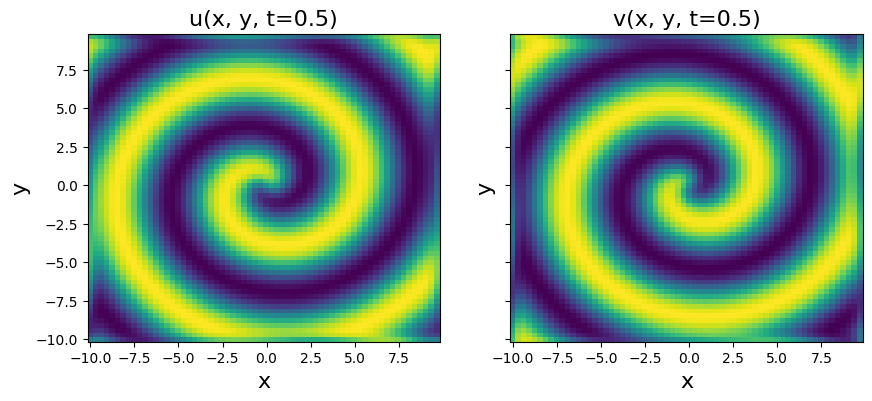

In [19]:
from numpy.fft import fft2, ifft2

# Define the reaction-diffusion PDE in the Fourier (kx, ky) space
def reaction_diffusion(t, uvt, K22, d1, d2, beta, n, N):
    ut = np.reshape(uvt[:N], (n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n))
    u = np.real(ifft2(ut))
    v = np.real(ifft2(vt))
    u3 = u ** 3
    v3 = v ** 3
    u2v = (u ** 2) * v
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fft2(u - u3 - uv2 + beta * u2v + beta * v3)), (N, 1))
    vtrhs = np.reshape((fft2(v - u2v - v3 - beta * u3 - beta * uv2)), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, 
             -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
t = np.linspace(0, 10, int(10 / 0.1))
d1 = 0.1
d2 = 0.1
beta = 1.0
L = 20  # Domain size in X and Y directions
n = 64  # Number of spatial points in each direction
N = n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), 
                                  np.linspace(-n2, -1, n2)))
ky = kx
# Get 2D meshes in (x, y) and (kx, ky)
X, Y = np.meshgrid(x, y)
KX, KY = np.meshgrid(kx, ky)
K2 = KX ** 2 + KY ** 2
K22 = np.reshape(K2, (N, 1))

m = 1  # number of spirals

# define our solution vectors
u = np.zeros((len(x), len(y), len(t)))
v = np.zeros((len(x), len(y), len(t)))

# Initial conditions
u[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)
v[:, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (np.reshape(fft2(u[:, :, 0]), (1, N)), 
         np.reshape(fft2(v[:, :, 0]), (1, N)))
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, 
    (t[0], t[-1]), 
    y0=uvt0, 
    t_eval=t, 
    args=(K22, d1, d2, beta, n, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, t) space from (kx, ky, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n))
    vt = np.reshape(uvsol[N:, j], (n, n))
    u[:, :, j] = np.real(ifft2(ut))
    v[:, :, j] = np.real(ifft2(vt))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X, Y, u[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, t=0.5)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X, Y, v[:, :, 10])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, t=0.5)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]

u_sol = u
v_sol = v

In [20]:
u = np.zeros((n, n, len(t), 2))
u[:, :, :, 0] = u_sol
u[:, :, :, 1] = v_sol

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

np.random.seed(100)
# Need to define the 2D spatial grid before calling the library
X, Y, T = np.meshgrid(x, y, t, indexing='ij')
XYT = np.transpose([X, Y, T], [1, 2, 3, 0])
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    is_uniform=True,
    periodic=True,
    K=100,
    include_interaction=False
)

In [21]:
# Fit the 2D reaction-diffusion equation, weak form style!
optimizer = ps.STLSQ(threshold=0.05, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

(x0)' = 1.000 x0 + -1.000 x0x0x0 + 1.000 x1x1x1 + -1.000 x0x1x1 + 1.000 x0x0x1 + 0.100 x0_22 + 0.100 x0_11
(x1)' = 1.000 x1 + -1.000 x0x0x0 + -1.000 x1x1x1 + -1.000 x0x1x1 + -1.000 x0x0x1 + 0.100 x1_22 + 0.100 x1_11


Okay, so we have captured the terms in the clean data case... can we repeat with some added noise?

In [22]:
# Need to increase the weak form mesh resolution a bit if data is noisy
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XYT,
    K=1000,
    is_uniform=True,
    periodic=True,
    include_interaction=True
)

# Initialize noisy data
rmse = mean_squared_error(u.flatten(), np.zeros(u.size), squared=False)
u_noisy = u + np.random.normal(0, rmse / 50.0, u.shape)  # Add 2% noise

# Fit the 2D reaction-diffusion equation with noise, weak form style!
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=weak_lib, optimizer=optimizer)
model.fit(u_noisy, quiet=True)
model.print()

(x0)' = 0.867 x0 + 0.167 x1 + -0.864 x0x0x0 + 0.817 x1x1x1 + -0.868 x0x1x1 + 0.812 x0x0x1 + 0.089 x0_22 + 0.088 x0_11
(x1)' = -0.122 x0 + 0.860 x1 + -0.864 x0x0x0 + -0.857 x1x1x1 + -0.864 x0x1x1 + -0.859 x0x0x1 + 0.089 x1_22 + 0.087 x1_11


The weak formulation works adequately with noise, but requires a relatively large K.

# Test weak form PDE functionality on 3D Reaction-Diffusion system
Can even use weak-form for 3D PDEs although this is getting computationally intensive! 

We will use a 3D reaction-diffusion equation called the Gray-Scott Equation. We are folllowing the example in Section 3.3.3 of Maddu, S., Cheeseman, B. L., Sbalzarini, I. F., & Müller, C. L. (2019). Stability selection enables robust learning of partial differential equations from limited noisy data. arXiv preprint arXiv:1907.07810. ([Link](https://arxiv.org/pdf/1907.07810.pdf)).
$$u_t = D_u\nabla^2 u - uv^2 + 0.014(1-u)$$
$$v_t = D_v\nabla^2 v + uv^2 - 0.067 v$$
We will need to generate some low-resolution data, because the memory requirements are very significant for a fully 3D problem. We can still get a pretty good model.

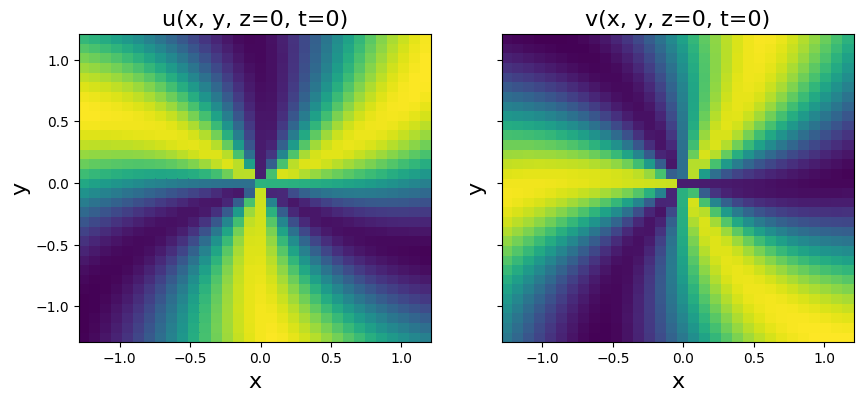

In [23]:
from numpy.fft import fftn, ifftn

# Define the reaction-diffusion PDE in the Fourier (kx, ky, kz) space
def reaction_diffusion(t, uvt, K22, d1, d2, n, N):
    ut = np.reshape(uvt[:N], (n, n, n))
    vt = np.reshape(uvt[N : 2 * N], (n, n, n))
    u = np.real(ifftn(ut, axes=[0, 1, 2]))
    v = np.real(ifftn(vt, axes=[0, 1, 2]))
    uv2 = u * (v ** 2)
    utrhs = np.reshape((fftn(0.014 * (1 - u) - uv2, axes=[0, 1, 2])), (N, 1))
    vtrhs = np.reshape((fftn(uv2 - 0.067 * v, axes=[0, 1, 2])), (N, 1))
    uvt_reshaped = np.reshape(uvt, (len(uvt), 1))
    uvt_updated = np.squeeze(
        np.vstack(
            (-d1 * K22 * uvt_reshaped[:N] + utrhs, 
             -d2 * K22 * uvt_reshaped[N:] + vtrhs)
        )
    )
    return uvt_updated


# Generate the data
dt = 0.1
t = np.linspace(0, 10, int(10 / dt))
d1 = 2e-2
d2 = 1e-2
L = 2.5  # Domain size in X, Y, Z directions
n = 32  # Number of spatial points in each direction
N = n * n * n
x_uniform = np.linspace(-L / 2, L / 2, n + 1)
x = x_uniform[:n]
y = x_uniform[:n]
z = x_uniform[:n]
n2 = int(n / 2)
# Define Fourier wavevectors (kx, ky, kz)
kx = (2 * np.pi / L) * np.hstack((np.linspace(0, n2 - 1, n2), 
                                  np.linspace(-n2, -1, n2)))
ky = kx
kz = kx
# Get 3D meshes in (x, y, z) and (kx, ky, kz)
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing="ij")
K2 = KX ** 2 + KY ** 2 + KZ ** 2
K22 = np.reshape(K2, (N, 1))

m = 3  # number of spirals

# define our solution vectors
u = np.zeros((n, n, n, len(t)))
v = np.zeros((n, n, n, len(t)))

# Initial conditions
u[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2 + Z ** 2)) * np.cos(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2 + Z ** 2))
)
v[:, :, :, 0] = np.tanh(np.sqrt(X ** 2 + Y ** 2 + Z ** 2)) * np.sin(
    m * np.angle(X + 1j * Y) - (np.sqrt(X ** 2 + Y ** 2 + Z ** 2))
)

# uvt is the solution vector in Fourier space, so below
# we are initializing the 2D FFT of the initial condition, uvt0
uvt0 = np.squeeze(
    np.hstack(
        (
            np.reshape(fftn(u[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
            np.reshape(fftn(v[:, :, :, 0], axes=[0, 1, 2]), (1, N)),
        )
    )
)

# Solve the PDE in the Fourier space, where it reduces to system of ODEs
uvsol = solve_ivp(
    reaction_diffusion, 
    (t[0], t[-1]), 
    y0=uvt0, 
    t_eval=t, 
    args=(K22, d1, d2, n, N)
)
uvsol = uvsol.y

# Reshape things and ifft back into (x, y, z, t) space from (kx, ky, kz, t) space
for j in range(len(t)):
    ut = np.reshape(uvsol[:N, j], (n, n, n))
    vt = np.reshape(uvsol[N:, j], (n, n, n))
    u[:, :, :, j] = np.real(ifftn(ut, axes=[0, 1, 2]))
    v[:, :, :, j] = np.real(ifftn(vt, axes=[0, 1, 2]))

# Plot to check if spiral is nicely reproduced
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.pcolor(X[:, :, 0], Y[:, :, 0], u[:, :, 0, 0])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('u(x, y, z=0, t=0)', fontsize=16)
plt.subplot(1, 2, 2)
plt.pcolor(X[:, :, 0], Y[:, :, 0], v[:, :, 0, 0])
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title('v(x, y, z=0, t=0)', fontsize=16)

dt = t[1] - t[0]
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

u_sol = u
v_sol = v

In [24]:
time = t
u = np.zeros((n, n, n, len(time), 2))
u[:, :, :, :, 0] = u_sol
u[:, :, :, :, 1] = v_sol
u_dot = ps.FiniteDifference(axis=3)._differentiate(u, dt)

# Odd polynomial terms in (u, v), up to second order derivatives in (u, v)
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]

# Need to define the 2D spatial grid before calling the library
X, Y, Z, T = np.meshgrid(x, y, z, time, indexing="ij")
spatiotemporal_grid = np.asarray([X, Y, Z, T])
spatiotemporal_grid = np.transpose(spatiotemporal_grid, axes=[1, 2, 3, 4, 0])
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=spatiotemporal_grid,
    is_uniform=True,
    include_interaction=False,
    include_bias=True,
    periodic=True,
    K=2000,
)

In [25]:
# Fit the 3D reaction-diffusion equation
optimizer = ps.SR3(threshold=1e-5, normalize_columns=True, max_iter=50)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, quiet=True)
model.print()

(x0)' = 0.014 1 + -0.018 x0 + -0.992 x0x1x1 + 0.016 x0_33 + 0.016 x0_22 + 0.017 x0_11
(x1)' = -0.071 x1 + 0.994 x0x1x1 + 0.008 x1_33 + 0.008 x1_22 + 0.008 x1_11


Correct equations are:
$$u_t = 0.02\nabla^2 u - uv^2 + 0.014(1-u)$$
$$v_t = 0.01\nabla^2 v + uv^2 - 0.067 v$$
So our model is pretty good!